In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [3]:
%matplotlib qt
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 11.73it/s]


Using control points [0.00000000e+00 0.00000000e+00 1.90241028e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


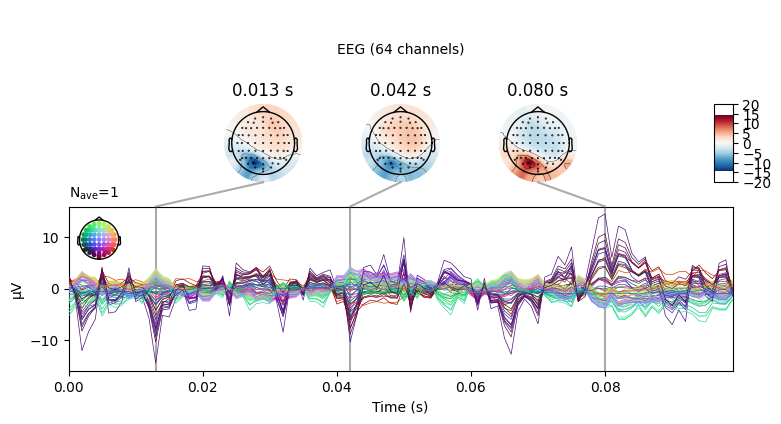

In [140]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=1e99)
settings = dict(number_of_sources=5, extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
B = evoked.data
S = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Gamma Maximum a-Posteriori

**db** number of sensors  
**ds** number of dipoles  
**n** number of time points  

**B** EEG matrix  
**S** source matrix  
**C** Covariance Matrix  
**Cb** Empirical (Data) Covariance Matrix  
**Sigma_b** Model Covariance Matrix  
**Sigma_s** Source Covariance Matrix  
**Sigma_e** Noise Covariance Matrix  


**E-Step**: find mean and cov of S given gamma_hat  
**M-Step**: update gammas  


In [151]:
# Parameters
alpha = 1e-6

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# some helper functions
def frob(x):
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    return np.sqrt(np.trace(x@x.T))

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)
# L /= np.linalg.norm(L, axis=0)
# Source Components
C = []
for i in range(ds):
    Ci = np.zeros((ds, ds))
    Ci[i,i] = 1
    C.append( Ci )
# Data Covariance Matrix
Cb = B @ B.T
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

In [145]:
max_iter = 50
for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    # E = sigma_s @ L.T @ np.linalg.inv( sigma_e + L @ sigma_s @ L.T ) @ B
    # term_1 = sigma_s @ L.T
    # term_2 = np.linalg.inv(sigma_e + L@sigma_s@L.T) @ L @ sigma_s
    # Cov = sigma_s - term_1 @ term_2
    sigma_b_inv = np.linalg.inv(sigma_b)
    for i in range(ds):
        # S[i, :] = np.sqrt( frob(E[i]) + np.trace(Cov) )
        # 27
        # term_1 = (1/(n*r[i])) * frob( gammas[i] * L[:,i].T @ sigma_b_inv @ B )
        # term_2 = (1/r[i]) * np.trace( gammas[i] * np.identity(db) - gammas[i] * L[:, i].T @ sigma_b_inv @ L[:, i] * gammas[i] )
        # gammas[i] = term_1 + term_2
        
        # 30
        term_1 = (gammas[i]/np.sqrt(n)) * frob( L[:, i].T @ sigma_b_inv @ B )
        # term_2 = 1 / np.sqrt((np.trace( L[:, i].T @ sigma_b_inv @ L[:, i] )))
        term_2 = 1 / np.sqrt((L[:, i].T @ sigma_b_inv @ L[:, i] ))
        
        gammas[i] = term_1 * term_2
    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

1283 :  35.832945734337834  atoms
1283 :  3.1211982110433994e-08  atoms
1283 :  6.424947643773111e-17  atoms
1283 :  2.0457594552362915e-25  atoms
1283 :  8.032546024907422e-34  atoms
1283 :  3.453498480692217e-42  atoms
1283 :  1.551828559068809e-50  atoms
1283 :  7.152175351804457e-59  atoms
1283 :  3.3500111968598006e-67  atoms
1283 :  1.5861836972587568e-75  atoms
1283 :  7.566288699403225e-84  atoms
1283 :  3.6278293492102705e-92  atoms
1283 :  1.7457018019367028e-100  atoms
1283 :  8.421429720148946e-109  atoms
1283 :  4.069767652894095e-117  atoms
1283 :  1.9692227353827658e-125  atoms
1283 :  9.53680318716646e-134  atoms
1283 :  4.621490916085255e-142  atoms
1283 :  2.2405477614061158e-150  atoms
1283 :  1.0865849919067843e-158  atoms


# Plot

Using control points [0.00106712 0.00287454 0.38859624]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


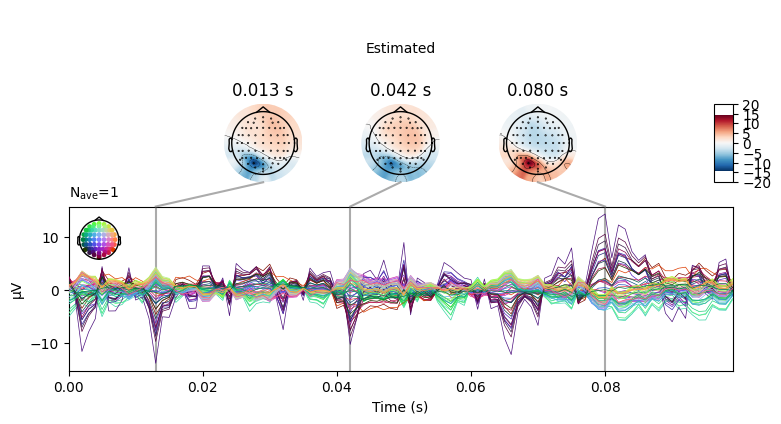

In [146]:
stc_ = stc.copy()
stc_.data = S / abs(S).max()
stc_.plot(**pp, brain_kwargs=dict(title="Esimated"))

evoked_ = mne.EvokedArray(L @ S, info).set_eeg_reference("average")
evoked_.plot_joint(title="Estimated")

In [152]:
max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    
    # term_1 = (gammas[i]/np.sqrt(n)) * np.sqrt(np.sum((L.T @ sigma_b_inv @ B )**2, axis=1))
    term_1 = (gammas/np.sqrt(n)) * np.sqrt(np.sum((L.T @ sigma_b_inv @ B )**2, axis=1))
    term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))
    
    gammas = term_1 * term_2
    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

1283 :  35.832945734337834  atoms
1283 :  3.121176686223768e-08  atoms
1283 :  6.424848420594029e-17  atoms
1283 :  2.0457331924801915e-25  atoms
1283 :  8.03248091337943e-34  atoms
1283 :  3.453465996109258e-42  atoms
1283 :  1.551801324528052e-50  atoms
1283 :  7.151954397352037e-59  atoms


C:\Users\Lukas\AppData\Local\Temp\ipykernel_13056\1590012598.py:10: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


1283 :  3.3498521654543255e-67  atoms
1283 :  1.586079521846396e-75  atoms
1283 :  7.56565018629867e-84  atoms
1283 :  3.627455973045948e-92  atoms
1283 :  1.7454907517361094e-100  atoms
1283 :  8.420266221126788e-109  atoms
1283 :  4.069138163329955e-117  atoms
1283 :  1.9688870178303752e-125  atoms
1283 :  9.53503261594139e-134  atoms
1283 :  4.620565302939494e-142  atoms
1283 :  2.2400672707838255e-150  atoms
1283 :  1.0863369725046564e-158  atoms


Using control points [0.00106634 0.00288403 0.38861663]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


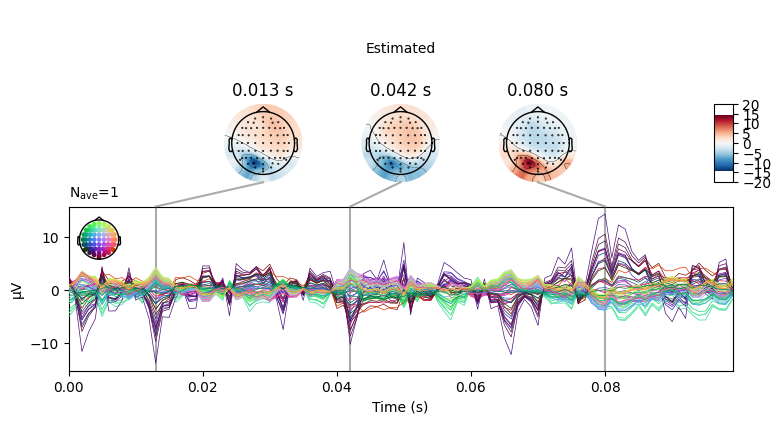

Using control points [0.00179542 0.00441026 0.32435917]
Using control points [0.00179141 0.00441157 0.32442894]


In [153]:
stc_ = stc.copy()
stc_.data = S / abs(S).max()
stc_.plot(**pp, brain_kwargs=dict(title="Esimated"))

evoked_ = mne.EvokedArray(L @ S, info).set_eeg_reference("average")
evoked_.plot_joint(title="Estimated")